In [1]:
from pyspark import SparkContext, SparkConf
import pandas as pd
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as mpe
import os
import sklearn as skl
#day of week börjar på söndag så söndag = 1

In [2]:
conf = SparkConf().setAppName('project')
sc = SparkContext(conf=conf)
sc

<SparkContext master=local[*] appName=project>

In [3]:
sc.version

'3.0.2'

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('project').config('spark.some.config.option', "some-value").getOrCreate()

In [9]:
def cast_columns(df, value_type):
    df = df.withColumn("month",df.month.cast('int'))
    df = df.withColumn("date",df.date.cast('int'))
    df = df.withColumn("value",df.value.cast(value_type))
    df = df.withColumn("hour",df.hour.cast('int'))
    df = df.withColumn("minute",df.minute.cast('int'))
    df = df.withColumn("weekday",df.weekday.cast('int'))
    return df

## SVR

In [55]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
def time_series_prediction(df, datatype, month): #df, int/float, month
    df = cast_columns(df, datatype)
    df = df.toPandas()
    df = df[df.month == month]
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors="coerce")
    df['target'] = df['value'].shift(-1)
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['hour_of_month'] = df.date*24+df.hour
    df = df.sort_values('hour_of_month')

    df_input = df[['hour_of_month', 'value']]
    df_input = df_input.groupby('hour_of_month').mean()

    df_input = df_input.reset_index()

    df_input = df_input.drop(columns='hour_of_month')
    train, test = df_input[1:len(df_input)-72], df_input[len(df_input)-72:]
    x_train = np.array(train.index.values)
    x_test = np.array(test.index.values)
    input_data = np.array(train)
    output_data = np.array(test)
    regr = svm.SVR()
    regr.fit(x_train.reshape(-1,1), input_data.reshape(-1,1))
    preds = regr.predict(output_data.reshape(-1,1))
    
    plt.plot(x_test, preds, label='predictions')
    plt.plot(x_test, output_data, label='target')
    plt.ylabel('Sensor Value')
    plt.xlabel('Hour of Month')
    plt.title('Predicting the last 72 hours of month '+str(month)+' with SVR gave an RMSE:'+ str(np.around(mean_squared_error(output_data, preds, squared=False), 3)))
    plt.legend()


L:\Anaconda\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


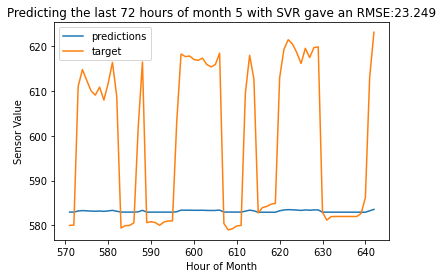

In [56]:
df = spark.read.csv('int_sensor_compressed/bedroom-bed-pressure.csv', header=True)
time_series_prediction(df, 'int', 5)


## SARIMA

In [41]:
df = spark.read.csv('int_sensor_compressed/bedroom-bed-pressure.csv', header=True)
df = cast_columns(df, 'int')
df = df.toPandas()
df = df[df.month == 5]
df['timestamp'] = pd.to_datetime(df['timestamp'], errors="coerce")
df['target'] = df['value'].shift(-1)
df['dayofyear'] = df['timestamp'].dt.dayofyear
df['hour_of_year'] = df.dayofyear*24+df.hour
df = df.sort_values('hour_of_year')

df_input = df[['hour_of_year', 'value']]
df_input = df_input.groupby('hour_of_year').mean()

df_input = df_input.reset_index()

df_input = df_input.drop(columns='hour_of_year')


In [15]:
df = spark.read.csv('int_sensor_compressed/bedroom-bed-pressure.csv', header=True)
df = cast_columns(df, 'int')
df = df.toPandas()
df = df[df.month == 5]
df['timestamp'] = pd.to_datetime(df['timestamp'], errors="coerce")
df['target'] = df['value'].shift(-1)
df['dayofyear'] = df['timestamp'].dt.dayofyear
df['hour_of_month'] = df.date*24+df.hour
df = df.sort_values('hour_of_month')
#df = df[df.month == 5]
#df = df[df.week == '20']

df_input = df[['hour_of_month', 'value']]
df_input = df_input.groupby('hour_of_month').mean()

df_input = df_input.reset_index()

df_input = df_input.drop(columns='hour_of_month')

In [16]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_input.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])#d=0

ADF Statistic: -4.941624
p-value: 0.000029


L:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(


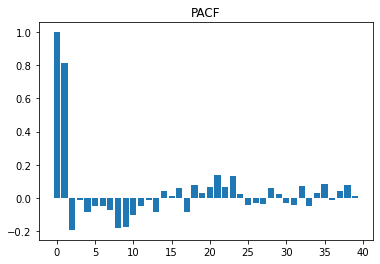

In [17]:
from statsmodels.graphics.tsaplots import pacf

pacf_vals = pacf(df_input)
num_lags = 40
plt.bar(range(num_lags), pacf_vals[:num_lags])
plt.title('PACF')
plt.show()

L:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
L:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


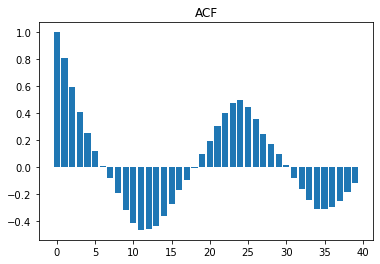

In [18]:
from statsmodels.graphics.tsaplots import acf
acf_vals = acf(df_input)
num_lags = 40
plt.bar(range(num_lags), acf_vals[:num_lags])
plt.title('ACF')
plt.show()

In [29]:
train, test = df_input[1:len(df_input)-72], df_input[len(df_input)-72:]

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
my_order = (1,0,1)
my_seasonal_order = (2,1,2,24)
model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)

In [22]:
model_fit = model.fit()

L:\Anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
print(model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                   value   No. Observations:                  570
Model:             SARIMAX(1, 0, 1)x(2, 1, [1, 2], 24)   Log Likelihood               -2054.582
Date:                                 Tue, 09 Nov 2021   AIC                           4123.163
Time:                                         22:03:08   BIC                           4153.281
Sample:                                              0   HQIC                          4134.937
                                                 - 570                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7176      0.038     18.924      0.000       0.643       0

In [46]:
predictions = model_fit.forecast(len(test))
residuals = test.value-predictions

Text(0, 0.5, 'Error')

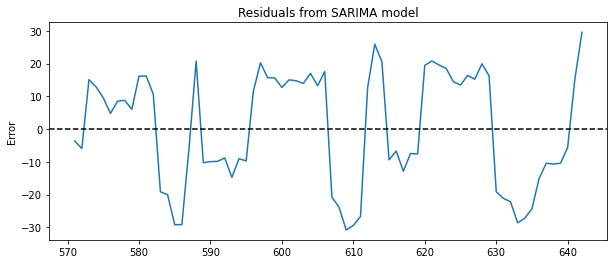

In [48]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0,linestyle='--', color='k')
plt.title('Residuals from SARIMA model')
plt.ylabel('Error')

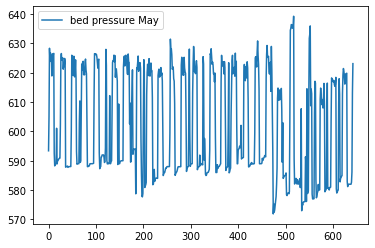

In [49]:
#plt.plot(predictions, label='prediction')
plt.plot(df_input, label='bed pressure May')
plt.legend()

In [50]:
print('RMSE:',np.sqrt(np.mean(residuals**2)))

RMSE: 17.132951687953675


In [51]:
print('RMSE',mean_squared_error(test, predictions, squared=False))

RMSE 17.132951687953675


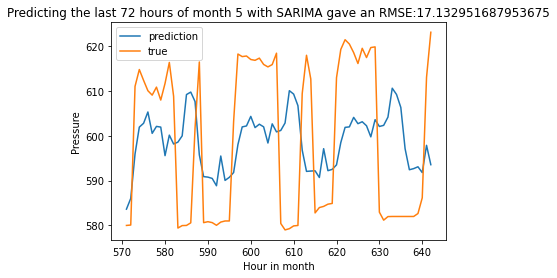

In [52]:
from sklearn.metrics import mean_squared_error
plt.plot(predictions, label='prediction')
plt.plot(test, label='true')
plt.xlabel('Hour in month')
plt.ylabel('Pressure') 
plt.title('Predicting the last 72 hours of month 5 with SARIMA gave an RMSE:'+str(mean_squared_error(test, predictions, squared=False)))
plt.legend()
plt.show()

In [57]:
def sarima_plot(order, seasonal_order):
    train, test = df_input[1:len(df_input)-72], df_input[len(df_input)-72:]
    my_order = order
    my_seasonal_order = seasonal_order
    model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))
    residuals = test.value-predictions
    plt.plot(predictions, label='prediction')
    plt.plot(test, label='true')
    plt.title('Predicting the last 72 hours of month 5 with SARIMA gave an RMSE:'+str(mean_squared_error(test, predictions, squared=False)))
    plt.legend()

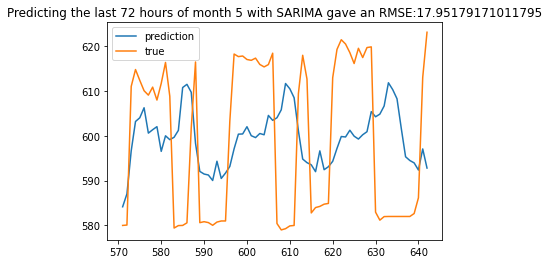

In [58]:
sarima_plot((1,0,1),(1,1,1,24))